<a href="https://colab.research.google.com/github/DocLock17/ISAR_Final/blob/main/Official_MAT_ImageClassifierV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modular Abstraction Tranfer Learning Image Classifier

A DeepMind based experiment in feature abstraction as applied to Deep-Q Reinforcement learning.


## Setup

#### Selector Menu

In [1]:
# Import and Unzip Hosted Dataset
CREATE_MISSING_DIRECTORIES = True #@param {type:"boolean"}
IMPORT_MAIN_DATA = True #@param {type:"boolean"}
IMPORT_SENTIMENT_DATA = True #@param {type:"boolean"}
IMPORT_MODEL_DATA = True #@param {type:"boolean"}

BATCH_SIZE =  128#@param {type:"integer"}

# Ranges 0 - 1
SCALED_ONE_ZERO = False #@param {type:"boolean"}

# Ranges -1 - 1
SCALED_ONE_ONE = True #@param {type:"boolean"}

IMAGE_SIZE = (104, 80)


MODEL_NAME = "m1_MAT_ImageClassifier_v3" #@param {type:"string"}
SLICE_ONE_NAME = "s1_MAT_ImageClassifier_v3" #@param {type:"string"}
SLICE_TWO_NAME = "s2_MAT_ImageClassifier_v3" #@param {type:"string"}
SLICE_THREE_NAME = "s3_MAT_ImageClassifier_v3" #@param {type:"string"}

EXTRACT_SLICE_ONE = True #@param {type:"boolean"}
EXTRACT_SLICE_TWO = True #@param {type:"boolean"}
EXTRACT_SLICE_THREE = True #@param {type:"boolean"}

TF_LITE_MODEL = True #@param {type:"boolean"}
ZIP_OUTPUT = True #@param {type:"boolean"}

#### Setup Model Output Directory

In [2]:
%%capture

import os

try:
  import google.colab
  COLAB = True
  
except:
  !pip install gdown
  COLAB = False

model_dir = 'ISAR_Model_Data'
data_dir = 'ISAR_Main_Classification'
transfer_dir = 'ISAR_Sentiment_Transfer'


if IMPORT_MAIN_DATA :
    if not os.path.exists(data_dir): ## Make it if it doesn't exist
      !gdown https://drive.google.com/uc?id=1P7o1x4ZpPbd16VQDwaMzllbN-tlfqqIH
      !unzip ISAR_Main_Classification.zip
      !rm ISAR_Main_Classification.zip
if IMPORT_SENTIMENT_DATA:
    if not os.path.exists(transfer_dir): ## Make it if it doesn't exist
      !gdown https://drive.google.com/uc?id=1UDUNnw04q5cvms5ibM6pNn-wXtJphXxZ
      !unzip ISAR_Sentiment_Transfer.zip
      !rm ISAR_Sentiment_Transfer.zip
if IMPORT_MODEL_DATA:
    if not os.path.exists(model_dir): ## Make it if it doesn't exist
      !gdown https://drive.google.com/uc?id=1IVw1bEAmMDiVeHfPPBWBfMj3h9WliumD
      !unzip ISAR_Model_Data.zip
      !rm ISAR_Model_Data.zip


In [3]:
if CREATE_MISSING_DIRECTORIES:  
  if not os.path.exists(data_dir): ## Make it if it doesn't exist
    print("Creating Main Data Directory")
    os.makedirs(data_dir)
  else:
    print("Main Data Directory Found")
  if not os.path.exists(transfer_dir): ## Make it if it doesn't exist
    print("Creating Transfer Data Directory")
    os.makedirs(transfer_dir)
  else:
    print("Transfer Data Directory Found")
  if not os.path.exists(model_dir): ## Make it if it doesn't exist
    print("Creating Model Directory")
    os.makedirs(model_dir)
  else:
    print("Model Directory Found")

Main Data Directory Found
Transfer Data Directory Found
Model Directory Found


#### Setup Imports

In [4]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
# from keras.layers import *
# from keras.models import Sequential
import keras
import tensorflow_hub as hub
from tensorflow.python.client import device_lib
from keras.callbacks import ModelCheckpoint

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print(device_lib.list_local_devices())

# Set Memory Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print(gpu)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


TF version: 2.4.1
Hub version: 0.11.0
Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## Data

Originally we Looked at Using Color Photos. However, this would be a bit unfair to our bot because the data is presented in a stack of grayscaled images. 

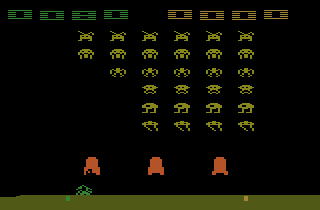
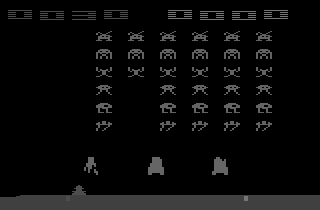


After Some Thought we decided to execute initial classification training on the same stacked grayscale frames our bot can expect to see in the "real" world. Similiar to DeepMinds original implementation our bot will stack 3 gray scale images (DeepMind uses 4 but says 3-5 is ideal). This process allows the bot to process temporal changes in a single frame and we can train it with a standard image data generator.

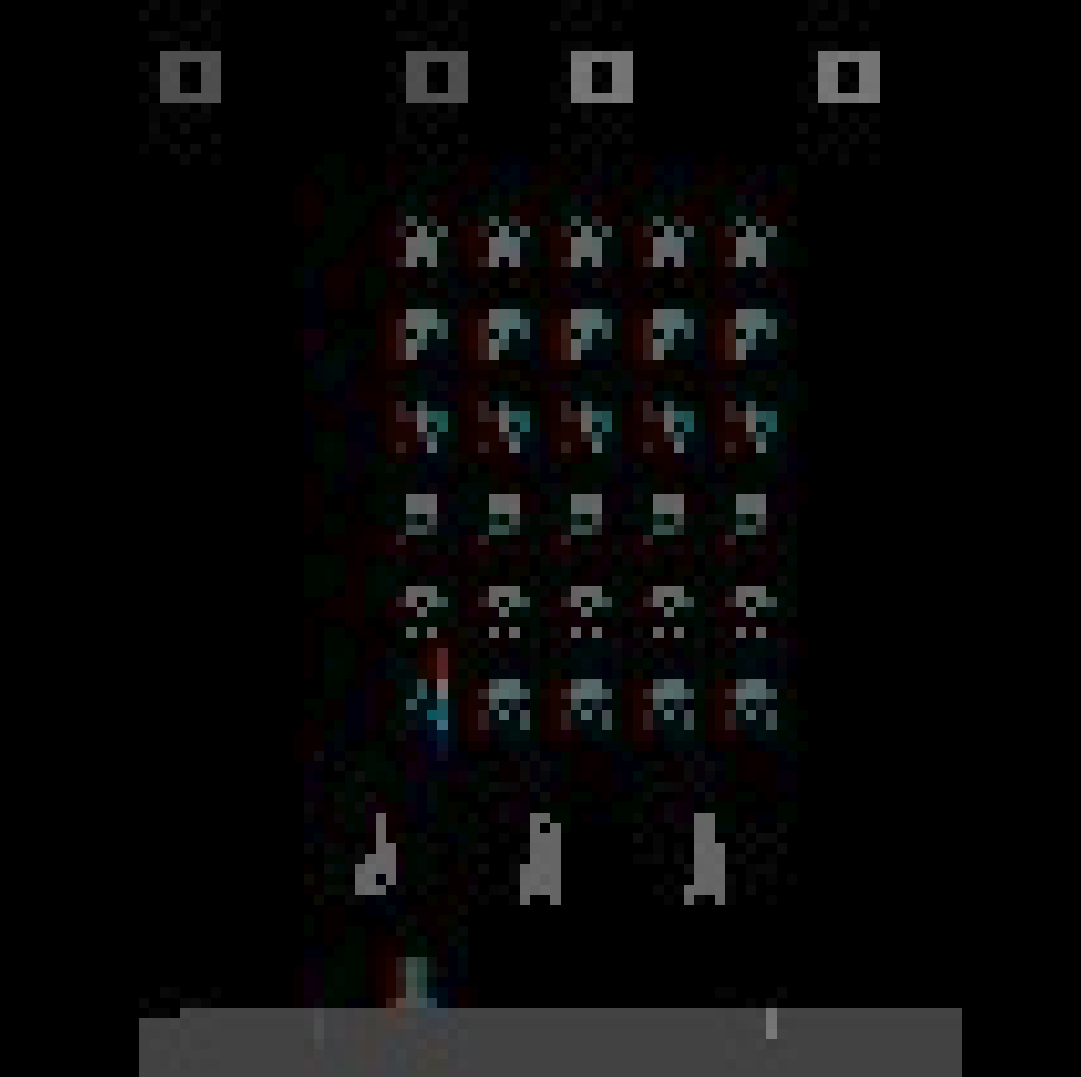

#### Setup Data Generator

In [5]:
#### Setup Data Generator
if SCALED_ONE_ZERO:
  datagen_kwargs = dict(rescale=1./255, validation_split=.10)

if SCALED_ONE_ONE:
  datagen_kwargs = dict(featurewise_center=True, samplewise_center=True,
                      rescale = 2/255, validation_split=.10)

dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=True, **dataflow_kwargs)

do_data_augmentation = True #@/param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=30,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 18000 images belonging to 12 classes.
Found 162000 images belonging to 12 classes.


## Create and Train Model

#### Changes?

### In the original architecture created by DeepMind frames were resized to 84 x 84, however, the ultimate goal of this project is to generalize across games so we will use 104 x 80 since it better represents the the game scale which will likely warp the representation of time the new scale isn't terribly computationally different and appears to train effectively in preliminary tests.

#### Define Model Architecture

In [6]:
# Slice One
s1_input_layer = tf.keras.Input(shape=IMAGE_SIZE + (3,))
s1_conv1 = tf.keras.layers.Conv2D(32, kernel_size=(8, 8),strides=4, activation='relu', name='S1_Conv1', \
                            kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0))(s1_input_layer)
s1_output = tf.keras.layers.Conv2D(64, kernel_size=(4, 4),strides=2, activation='relu', name='S1_Conv2', \
                            kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0))(s1_conv1)
s1_model = tf.keras.Model(inputs=s1_input_layer, outputs=s1_output)
s1_model.summary()


# Slice Two
s2_input_layer = tf.keras.Input(shape=(11, 8, 64))
s2_conv1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),strides=1, activation='relu', name='S2_Conv1', \
                            kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0))(s2_input_layer)
s2_flat_1 = tf.keras.layers.Flatten(name='S2_Flat1')(s2_conv1)
s2_output = tf.keras.layers.Dense(512, activation='relu', name='s2_Dense_1', \
                            kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0))(s2_flat_1)
s2_model = tf.keras.Model(inputs=s2_input_layer, outputs=s2_output)
s2_model.summary()


# Slice Three
s3_input_layer = tf.keras.Input(shape=(512))
s3_output = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax', name ='Final_Out', \
                            kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0))(s3_input_layer)
s3_model = tf.keras.Model(inputs=s3_input_layer, outputs=s3_output)
s3_model.summary()


model_input = tf.keras.Input(shape=(IMAGE_SIZE+(3,)))
s1_pass = s1_model(model_input)
s2_pass = s2_model(s1_pass)
s3_final_output = s3_model(s2_pass)
model = tf.keras.Model(inputs=model_input, outputs=s3_final_output)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 104, 80, 3)]      0         
_________________________________________________________________
S1_Conv1 (Conv2D)            (None, 25, 19, 32)        6176      
_________________________________________________________________
S1_Conv2 (Conv2D)            (None, 11, 8, 64)         32832     
Total params: 39,008
Trainable params: 39,008
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 11, 8, 64)]       0         
_________________________________________________________________
S2_Conv1 (Conv2D)            (None, 9, 6, 64)          36928     
________________________________________

#### Setup Checkpoints

In [7]:
# Checkpoint
model_checkpoint_path = model_dir + "/ISAR_Production_Models/" + MODEL_NAME + "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [8]:
model.trainable = True #@param {type:"boolean"}

s1_model.trainable = True #@param {type:"boolean"}

s2_model.trainable = True #@param {type:"boolean"}

s3_model.trainable = True #@param {type:"boolean"}

model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.0042, momentum=0.87),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.25),
  metrics=['accuracy'])

#### Training the model

In [9]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=1, steps_per_epoch=steps_per_epoch, callbacks=callbacks_list,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1265/1265 [==============================] - 463s 354ms/step - loss: 1.5583 - accuracy: 0.7689 - val_loss: 1.1753 - val_accuracy: 0.9915

Epoch 00001: val_accuracy improved from -inf to 0.99152, saving model to ISAR_Model_Data/ISAR_Production_Models/m1_MAT_ImageClassifier_v3weights-improvement-01-0.99.hdf5


#### Evaluate the model

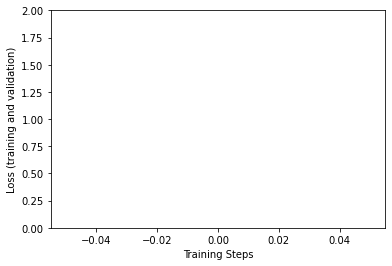

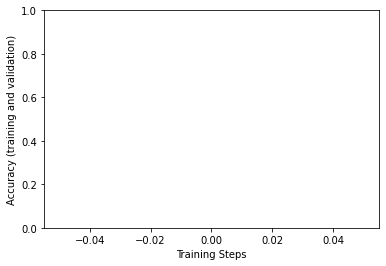

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

#### Toggle Trainable

In [11]:
## Lets try to push some of the distinctions to the back

model.trainable = True #@param {type:"boolean"}

s1_model.trainable = True #@param {type:"boolean"}

s2_model.trainable = True #@param {type:"boolean"}

s3_model.trainable = False #@param {type:"boolean"}

model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.0042, momentum=0.87),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.25),
  metrics=['accuracy'])

#### Train More?

In [12]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=1, steps_per_epoch=steps_per_epoch, callbacks=callbacks_list,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1265/1265 [==============================] - 438s 346ms/step - loss: 1.1947 - accuracy: 0.9597 - val_loss: 1.1591 - val_accuracy: 0.9931

Epoch 00001: val_accuracy improved from 0.99152 to 0.99308, saving model to ISAR_Model_Data/ISAR_Production_Models/m1_MAT_ImageClassifier_v3weights-improvement-01-0.99.hdf5


#### Evaluate the model

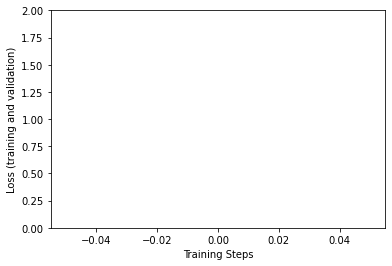

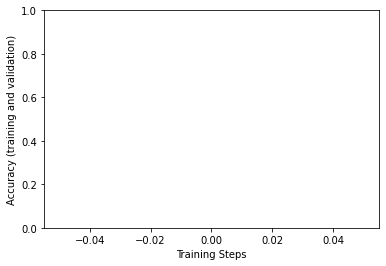

In [13]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

#### Toggle Trainable

In [14]:
# Couple more to let the model balance
model.trainable = True #@param {type:"boolean"}

s1_model.trainable = True #@param {type:"boolean"}

s2_model.trainable = True #@param {type:"boolean"}

s3_model.trainable = True #@param {type:"boolean"}

model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.0042, momentum=0.87),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.25),
  metrics=['accuracy'])

#### Train More?

In [15]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=1, steps_per_epoch=steps_per_epoch, callbacks=callbacks_list,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1265/1265 [==============================] - 434s 342ms/step - loss: 1.1644 - accuracy: 0.9727 - val_loss: 1.1300 - val_accuracy: 0.9965

Epoch 00001: val_accuracy improved from 0.99308 to 0.99648, saving model to ISAR_Model_Data/ISAR_Production_Models/m1_MAT_ImageClassifier_v3weights-improvement-01-1.00.hdf5


#### Evaluate the model

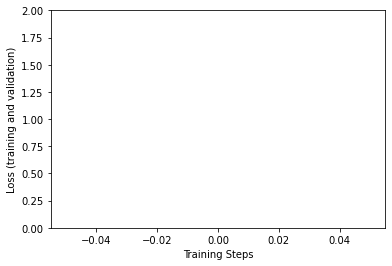

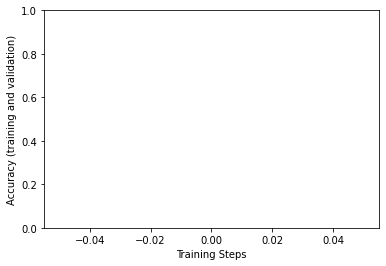

In [16]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

## Test and Validate

#### Testing the Model

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


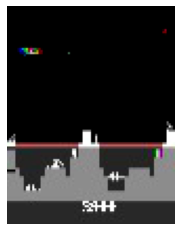

True label: Atlantis-vNoRewardX
Predicted label: Atlantis-vNoRewardX


In [17]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

#### Validate Model

Image batch shape:  (128, 104, 80, 3)
Label batch shape:  (128, 12)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


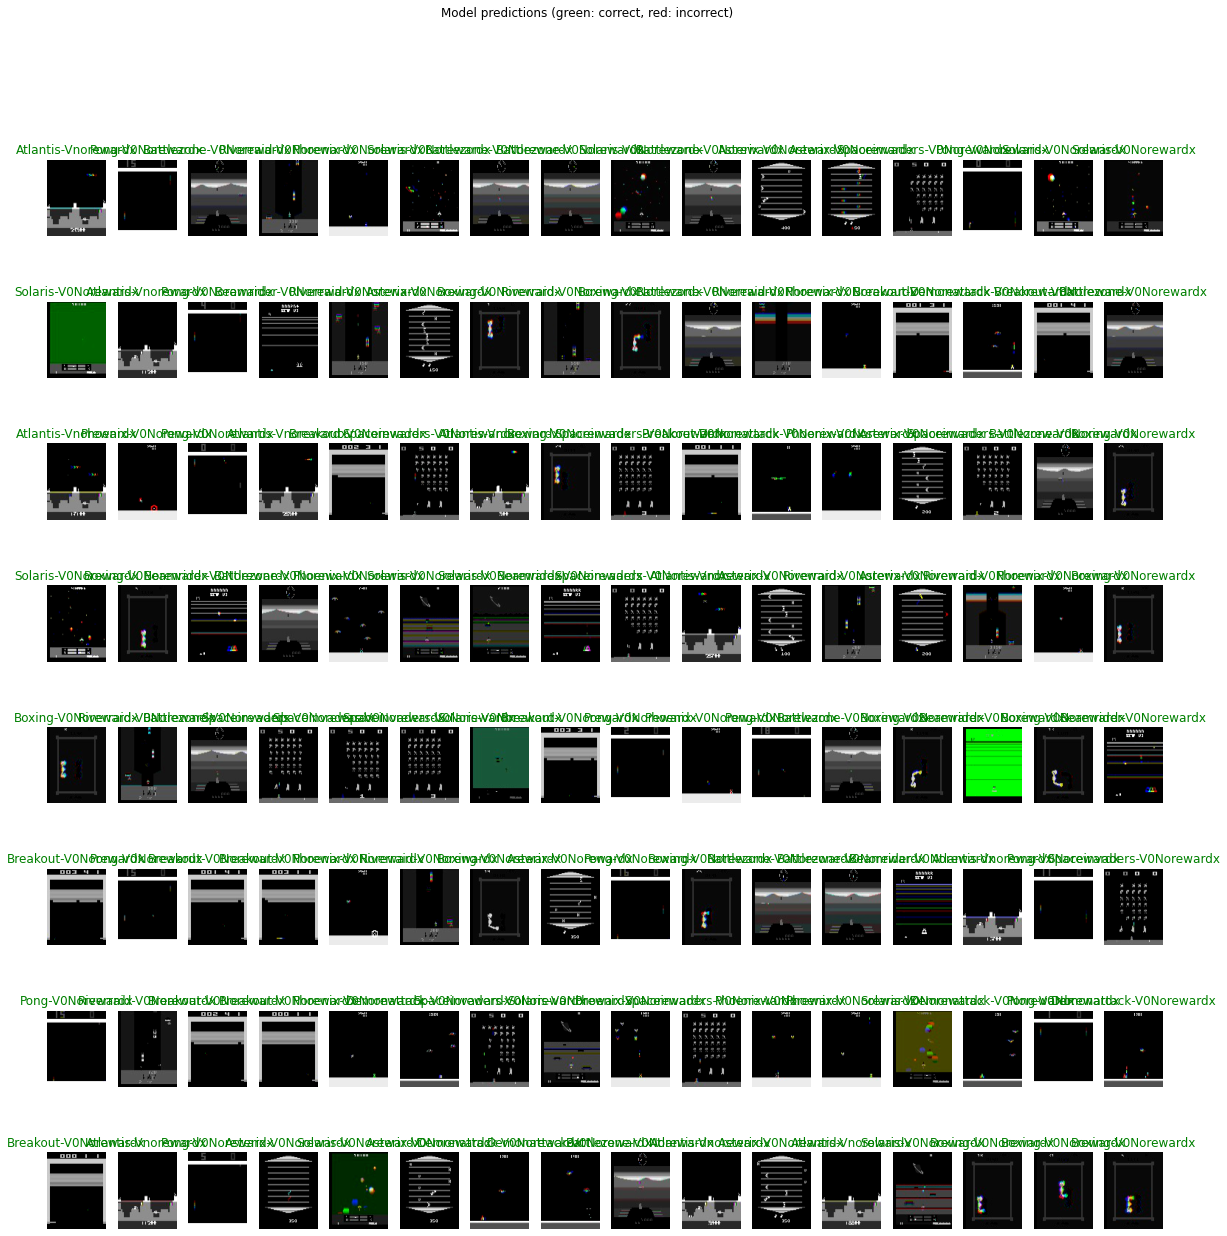

In [18]:
import math

class_labels = sorted(valid_generator.class_indices.items(), key=lambda pair:pair[1])
class_labels = np.array([key.title() for key, value in class_labels])

for image_batch, label_batch in valid_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

label_id = np.argmax(label_batch, axis=-1)
predicted_class_floats = model.predict(image_batch)

predicted_index = np.argmax(predicted_class_floats, axis=-1)
predicted_label_batch = class_labels[predicted_index]

sqr = math.sqrt(BATCH_SIZE)
# if BATCH_SIZE % sqr == 0:
#   plt.figure(figsize=(sqr+12,sqr+12))

base = BATCH_SIZE/8
if base % 1 != 0:
  print("fix me")
else:
  plt.figure(figsize=(20,20))
  plt.subplots_adjust(hspace=0.5)
  for n in range(BATCH_SIZE):
    plt.subplot(8,base,n+1)
    plt.imshow(np.clip(image_batch[n], 0, 1))
    color = "green" if predicted_index[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Saving the Model

#### Creating TFserve Version for API Deployment & Slices for transfer learning

In [19]:
saved_model_path = model_dir + "/ISAR_Production_Models/" + MODEL_NAME
tf.saved_model.save(model, saved_model_path)

if EXTRACT_SLICE_ONE:
    tf.saved_model.save(s1_model, model_dir + "/ISAR_Production_Models/" + SLICE_ONE_NAME)
    
if EXTRACT_SLICE_TWO:
    tf.saved_model.save(s2_model, model_dir + "/ISAR_Production_Models/" + SLICE_TWO_NAME)

if EXTRACT_SLICE_THREE:
    tf.saved_model.save(s3_model, model_dir + "/ISAR_Production_Models/" + SLICE_THREE_NAME)

INFO:tensorflow:Assets written to: ISAR_Model_Data/ISAR_Production_Models/m1_MAT_ImageClassifier_v3/assets
INFO:tensorflow:Assets written to: ISAR_Model_Data/ISAR_Production_Models/s1_MAT_ImageClassifier_v3/assets
INFO:tensorflow:Assets written to: ISAR_Model_Data/ISAR_Production_Models/s2_MAT_ImageClassifier_v3/assets
INFO:tensorflow:Assets written to: ISAR_Model_Data/ISAR_Production_Models/s3_MAT_ImageClassifier_v3/assets


#### Creating a TFlite Version For Edge Device Deployment

In [20]:
if TF_LITE_MODEL:
  optimize_lite_model = True  #@param {type:"boolean"}
  num_calibration_examples = 128  #@param {type:"slider", min:0, max:1000, step:1}
  representative_dataset = None
  if optimize_lite_model and num_calibration_examples:
    representative_dataset = lambda: itertools.islice(
        ([image[None, ...]] for batch, _ in train_generator for image in batch),
        num_calibration_examples)

  converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
  if optimize_lite_model:
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if representative_dataset: 
      converter.representative_dataset = representative_dataset
  lite_model_content = converter.convert()

  with open(model_dir + "/ISAR_Production_Models/" + MODEL_NAME + "_TF_LITE", "wb") as f:
    f.write(lite_model_content)
  print("Wrote %sTFLite model of %d bytes." %
        ("optimized " if optimize_lite_model else "", len(lite_model_content)))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Wrote optimized TFLite model of 1863200 bytes.


#### Load TFlite for Evalutation

In [21]:
if TF_LITE_MODEL:
  interpreter = tf.lite.Interpreter(model_content=lite_model_content)
  def lite_model(images):
    interpreter.allocate_tensors()
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
    interpreter.invoke()
    return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

#### Evaluate TFlite Version

In [22]:
if TF_LITE_MODEL:
  num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
  eval_dataset = ((image, label)  # TFLite expects batch size 1.
                  for batch in train_generator
                  for (image, label) in zip(*batch))
  count = 0
  count_lite_tf_agree = 0
  count_lite_correct = 0
  for image, label in eval_dataset:
    probs_lite = lite_model(image[None, ...])[0]
    probs_tf = model(image[None, ...]).numpy()[0]
    y_lite = np.argmax(probs_lite)
    y_tf = np.argmax(probs_tf)
    y_true = np.argmax(label)
    count +=1
    if y_lite == y_tf: count_lite_tf_agree += 1
    if y_lite == y_true: count_lite_correct += 1
    if count >= num_eval_examples: break
  print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
        (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
  print("TF Lite model is accurate on %d of %d examples (%g%%)." %
        (count_lite_correct, count, 100.0 * count_lite_correct / count))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


TF Lite model agrees with original model on 50 of 50 examples (100%).
TF Lite model is accurate on 50 of 50 examples (100%).


In [23]:
%%capture
if ZIP_OUTPUT:
  zip = !zip -r ISAR_Model_Data_Output.zip ISAR_Model_Data